# Consumer expenditure categorization

*NOTE: Due to the size of the dataset, this notebook will not run on MyBinder.*

### Why relational learning matters

This example demonstrates how powerful a real relational learning algorithm can be. Based on a public-domain dataset on consumer behavior, we use a propostionalization algorithm to predict whether purchases were made as a gift. We show that with relational learning, we can get an AUC of over 90%. The generated features would have been impossible to build by hand or by using brute-force approaches.

Summary:

- Prediction type: __Classification model__
- Domain: __Retail__
- Prediction target: __If a purchase is a gift__ 
- Source data: __Relational data set, 4 tables__
- Population size: __2.020.634__

_Author: Patrick Urbanke_

# Background

Relational learning is one of the most underappreciated fields of machine learning. Even though relational learning is very relevant to many real world data science projects, many data scientists don't even know what relational learning is. 

There are many subdomains of relational learning, but the most important one is extracting features from relational data: Most business data is relational, meaning that it is spread out over several relational tables. However, most machine learning algorithms require that the data be presented in the form of a single flat table. So we need to extract features from our relational data. Some people also call this data wrangling.

Most data scientists we know extract features from relational data manually or by using crude, brute-force approaches (randomly generate thousands of features and then do a feature selection). This is very time-consuming and does not produce good features.

### The challenge

The Consumer Expenditure Data Set is a public domain data set provided by the American Bureau of Labor Statistics (https://www.bls.gov/cex/pumd.htm). It includes the diary entries, where American consumers are asked to keep diaries of the products they have purchased each month.

These consumer goods are categorized using a six-digit classification system the UCC. This system is hierarchical, meaning that every digit represents an increasingly granular category.

For instance, all UCC codes beginning with ‘200’ represent beverages. UCC codes beginning with ‘20011’ represents beer and ‘200111’ represents ‘beer and ale’ and ‘200112’ represents ‘nonalcoholic beer’ (https://www.bls.gov/cex/pumd/ce_pumd_interview_diary_dictionary.xlsx).

The diaries also contain a flag that indicates whether the product was purchased as a gift. The challenge is to predict that flag using other information in the diary entries.

This can be done based on the following considerations:

1. Some items are _less likely to be purchased as gifts_ than others (for instance, it is unlikely that toilet paper is ever purchased as a gift).

2. Items that diverge from the _usual consumption patterns_ are more likely to be gifts.

In total, there are three tables which we find interesting:

1. EXPD, which contains information on the _consumer expenditures_, including the target variable GIFT.

2. FMLD, which contains socio-demographic information on the _households_.

3. MEMD, which contains socio-demographic information on each _member of the households_.


### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

# Analysis

In [1]:
import datetime
import os
from urllib import request
import time
import zipfile

import matplotlib.pyplot as plt
%matplotlib inline

import getml

In [2]:
getml.engine.launch(in_memory=True)
getml.engine.set_project("consumer_expenditures")

getML engine is already running.


Loading pipelines...
[========================================] 100%


Connected to project 'consumer_expenditures'
http://localhost:1709/#/listprojects/consumer_expenditures/


## 1. Loading data

### 1.1 Download from source


In [3]:
conn = getml.database.connect_mysql(
    host="relational.fit.cvut.cz",
    dbname="ConsumerExpenditures",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default',
           dbname='ConsumerExpenditures',
           dialect='mysql',
           host='relational.fit.cvut.cz',
           port=3306)

In [4]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if getml.data.exists(name):
        return getml.data.load_data_frame(name)
    data_frame = getml.data.DataFrame.from_db(
        name=name,
        table_name=name,
        conn=conn
    )
    data_frame.save()
    return data_frame

In [5]:
households = load_if_needed("HOUSEHOLDS")
household_members = load_if_needed("HOUSEHOLD_MEMBERS")
expenditures = load_if_needed("EXPENDITURES")

In [6]:
households

name,YEAR,INCOME_RANK,INCOME_RANK_1,INCOME_RANK_2,INCOME_RANK_3,INCOME_RANK_4,INCOME_RANK_5,INCOME_RANK_MEAN,AGE_REF,HOUSEHOLD_ID
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,2015,0.3044,0.1448,0.1427,0.1432,0.1422,0.1382,0.127,66,03111041
1,2015,0.3063,0.1462,0.1444,0.1446,0.1435,0.1395,0.1283,66,03111042
2,2015,0.6931,0.6222,0.6204,0.623,0.6131,0.6123,0.6207,48,03111051
3,2015,0.6926,0.6216,0.6198,0.6224,0.6125,0.6117,0.6201,48,03111052
4,2015,0.2817,0.113,0.1128,0.1098,0.1116,0.1092,0.0951,37,03111061
,...,...,...,...,...,...,...,...,...,...
56807,2019,0.4828,0.4106,0.3603,0.3958,0.377,0.3984,0.3769,67,04362582
56808,2019,0.6644,0.5975,0.6026,0.5949,0.596,0.6002,0.6,52,04362661
56809,2019,0.6639,0.597,0.6021,0.5944,0.5955,0.5997,0.5995,52,04362662


In [7]:
household_members

name,YEAR,AGE,HOUSEHOLD_ID,MARITAL,SEX,WORK_STATUS
role,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string
0,2015,66,03111041,1,1,NULL
1,2015,66,03111042,1,1,NULL
2,2015,56,03111091,1,1,NULL
3,2015,56,03111092,1,1,NULL
4,2015,50,03111111,1,1,1
,...,...,...,...,...,...
137350,2019,22,04362422,5,2,NULL
137351,2019,11,04362431,5,2,NULL
137352,2019,11,04362432,5,2,NULL


In [8]:
expenditures

name,YEAR,MONTH,COST,GIFT,IS_TRAINING,EXPENDITURE_ID,HOUSEHOLD_ID,PRODUCT_CODE
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,2015,1,3.89,0,1,1,03111041,010210
1,2015,1,4.66,0,1,10,03111041,120310
2,2015,2,9.79,0,1,100,03111051,190211
3,2015,2,2.95,0,1,1000,03111402,040510
4,2015,1,2.12,0,1,10000,03114161,190321
,...,...,...,...,...,...,...,...
2020629,2017,6,1.99,0,1,999995,03708582,150110
2020630,2017,6,3.619,0,1,999996,03708582,150110
2020631,2017,6,5.2727,0,1,999997,03708582,150211


### 1.2 Prepare data for getML

We now have to assign roles to the columns.

In [9]:
households.set_role("HOUSEHOLD_ID", getml.data.roles.join_key)
households.set_role(households.roles.unused_float, getml.data.roles.numerical)

households

name,HOUSEHOLD_ID,YEAR,INCOME_RANK,INCOME_RANK_1,INCOME_RANK_2,INCOME_RANK_3,INCOME_RANK_4,INCOME_RANK_5,INCOME_RANK_MEAN,AGE_REF
role,join_key,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
0,03111041,2015,0.3044,0.1448,0.1427,0.1432,0.1422,0.1382,0.127,66
1,03111042,2015,0.3063,0.1462,0.1444,0.1446,0.1435,0.1395,0.1283,66
2,03111051,2015,0.6931,0.6222,0.6204,0.623,0.6131,0.6123,0.6207,48
3,03111052,2015,0.6926,0.6216,0.6198,0.6224,0.6125,0.6117,0.6201,48
4,03111061,2015,0.2817,0.113,0.1128,0.1098,0.1116,0.1092,0.0951,37
,...,...,...,...,...,...,...,...,...,...
56807,04362582,2019,0.4828,0.4106,0.3603,0.3958,0.377,0.3984,0.3769,67
56808,04362661,2019,0.6644,0.5975,0.6026,0.5949,0.596,0.6002,0.6,52
56809,04362662,2019,0.6639,0.597,0.6021,0.5944,0.5955,0.5997,0.5995,52


In [10]:
household_members.set_role("HOUSEHOLD_ID", getml.data.roles.join_key)
household_members.set_role(household_members.roles.unused_float, getml.data.roles.numerical)
household_members.set_role(household_members.roles.unused_string, getml.data.roles.categorical)

household_members

name,HOUSEHOLD_ID,MARITAL,SEX,WORK_STATUS,YEAR,AGE
role,join_key,categorical,categorical,categorical,numerical,numerical
0,03111041,1,1,NULL,2015,66
1,03111042,1,1,NULL,2015,66
2,03111091,1,1,NULL,2015,56
3,03111092,1,1,NULL,2015,56
4,03111111,1,1,1,2015,50
,...,...,...,...,...,...
137350,04362422,5,2,NULL,2019,22
137351,04362431,5,2,NULL,2019,11
137352,04362432,5,2,NULL,2019,11


In [11]:
year = expenditures["YEAR"]
month = expenditures["MONTH"]

ts_strings = year + "/" + month

expenditures["TIME_STAMP"] = ts_strings.as_ts(["%Y/%n"])

In [12]:
expenditures.set_role("HOUSEHOLD_ID", getml.data.roles.join_key)
expenditures.set_role("GIFT", getml.data.roles.target)
expenditures.set_role("COST", getml.data.roles.numerical)
expenditures.set_role(["PRODUCT_CODE", "MONTH", "YEAR"], getml.data.roles.categorical)
expenditures.set_role("TIME_STAMP", getml.data.roles.time_stamp)

expenditures.set_subroles("PRODUCT_CODE", getml.data.subroles.include.substring)

expenditures

name,TIME_STAMP,HOUSEHOLD_ID,GIFT,MONTH,YEAR,PRODUCT_CODE,COST,IS_TRAINING,EXPENDITURE_ID
role,time_stamp,join_key,target,categorical,categorical,categorical,numerical,unused_float,unused_string
unit,"time stamp, comparison only",,,,,,,,
subroles:,,,,,,,,,
- include,,,,,,substring,,,
0,2015-01-01,03111041,0,1,2015,010210,3.89,1,1
1,2015-01-01,03111041,0,1,2015,120310,4.66,1,10
2,2015-02-01,03111051,0,2,2015,190211,9.79,1,100
3,2015-02-01,03111402,0,2,2015,040510,2.95,1,1000
4,2015-01-01,03114161,0,1,2015,190321,2.12,1,10000
,...,...,...,...,...,...,...,...,...


In [13]:
split = expenditures.rowid.as_str().update(expenditures.IS_TRAINING == 1, "train").update(expenditures.IS_TRAINING == 0, "test")
split

,
0,train
1,train
2,train
3,train
4,train
,...


## 2. Predictive modeling

Enough with the data preparation. Let's get to the fun part: Extracting the features.

### 2.1 Defining the data model

First, we define the data model.

What we want to do is the following: 

1. We want to compare every expenditure made to all *expenditures by the same household* (EXPD).

2. We want to check out whether *certain kinds of items have been purchased as a gift in the past* (EXPD).

2. We want to aggregate all available information on the *individual members of the household* (MEMD).



In [14]:
star_schema = getml.data.StarSchema(alias="POPULATION", population=expenditures, split=split)

star_schema.join(
    expenditures,
    on="HOUSEHOLD_ID",
    time_stamps="TIME_STAMP"
)

star_schema.join(
    households,
    on="HOUSEHOLD_ID",
    relationship=getml.data.relationship.many_to_one,
)

star_schema.join(
    household_members,
    on="HOUSEHOLD_ID",
)

star_schema

data model

  POPULATION:
    columns:
    - MONTH: categorical
    - YEAR: categorical
    - PRODUCT_CODE: categorical
    - HOUSEHOLD_ID: join_key
    - COST: numerical
    - ...

    joins:
    - right: 'EXPENDITURES'
      on: (POPULATION.HOUSEHOLD_ID, EXPENDITURES.HOUSEHOLD_ID)
      time_stamps: (POPULATION.TIME_STAMP, EXPENDITURES.TIME_STAMP)
      relationship: 'many-to-many'
      lagged_targets: False
    - right: 'HOUSEHOLDS'
      on: (POPULATION.HOUSEHOLD_ID, HOUSEHOLDS.HOUSEHOLD_ID)
      relationship: 'many-to-one'
      lagged_targets: False
    - right: 'HOUSEHOLD_MEMBERS'
      on: (POPULATION.HOUSEHOLD_ID, HOUSEHOLD_MEMBERS.HOUSEHOLD_ID)
      relationship: 'many-to-many'
      lagged_targets: False

  EXPENDITURES:
    columns:
    - MONTH: categorical
    - YEAR: categorical
    - PRODUCT_CODE: categorical
    - HOUSEHOLD_ID: join_key
    - COST: numerical
    - ...

  HOUSEHOLDS:
    columns:
    - HOUSEHOLD_ID: join_key
    - YEAR: numerical
    - INCOME_RANK: numerical
    - INCOME_RANK_1: numerical
    - INCOME_RANK_2: numerical
    - ...

  HOUSEHOLD_MEMBERS:
    columns:
    - MARITAL: categorical
    - SEX: categorical
    - WORK_STATUS: categorical
    - HOUSEHOLD_ID: join_key
    - YEAR: numerical
    - ...


container

  population
      subset   name              rows   type
  0   test     EXPENDITURES    387583   View
  1   train    EXPENDITURES   1633051   View

  peripheral
      name                   rows   type     
  0   EXPENDITURES        2020634   DataFrame
  1   HOUSEHOLDS            56812   DataFrame
  2   HOUSEHOLD_MEMBERS    137355   DataFrame

### 2.2 Setting the hyperparameters

We use `XGBoost` as our predictor and `FastProp` (short for fast propsitionalization) to generate our features. You are free to play with the hyperparameters.

In [15]:
ucc1 = getml.preprocessors.Substring(0, 1)
ucc2 = getml.preprocessors.Substring(0, 2)
ucc3 = getml.preprocessors.Substring(0, 3)
ucc4 = getml.preprocessors.Substring(0, 4)
ucc5 = getml.preprocessors.Substring(0, 5)

mapping = getml.preprocessors.Mapping(multithreading=False)

fast_prop = getml.feature_learning.FastProp(
    aggregation=getml.feature_learning.FastProp.agg_sets.All,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
    sampling_factor=0.1,
    num_features=100,
)

relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
    num_features=20,
)

feature_selector = getml.predictors.XGBoostClassifier()

predictor = getml.predictors.XGBoostClassifier(
    booster="gbtree",
    n_estimators=100,
    max_depth=7,
    reg_lambda=0.0,
    n_jobs=1
)

In [16]:
pipe1 = getml.pipeline.Pipeline(
    tags=["FastProp"],
    data_model=star_schema.data_model,
    share_selected_features=0.4,
    preprocessors=[mapping],
    feature_learners=fast_prop,
    feature_selectors=feature_selector,
    predictors=predictor
)

pipe1

Pipeline(data_model='POPULATION',
         feature_learners=['FastProp'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['EXPENDITURES', 'HOUSEHOLDS', 'HOUSEHOLD_MEMBERS'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.4,
         tags=['FastProp'])

In [17]:
pipe2 = getml.pipeline.Pipeline(
    tags=["Relboost"],
    data_model=star_schema.data_model,
    share_selected_features=0.9,
    preprocessors=[ucc1, ucc2, ucc3, ucc4, ucc5, mapping],
    feature_learners=relboost,
    feature_selectors=feature_selector,
    predictors=predictor
)

pipe2

Pipeline(data_model='POPULATION',
         feature_learners=['Relboost'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['EXPENDITURES', 'HOUSEHOLDS', 'HOUSEHOLD_MEMBERS'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Substring', 'Substring', 'Substring', 'Substring', 'Substring',
                        'Mapping'],
         share_selected_features=0.9,
         tags=['Relboost'])

In [18]:
pipe3 = getml.pipeline.Pipeline(
    tags=["FastProp", "Relboost"],
    data_model=star_schema.data_model,
    share_selected_features=0.2,
    preprocessors=[mapping],
    feature_learners=[fast_prop, relboost],
    feature_selectors=feature_selector,
    predictors=predictor
)

pipe3

Pipeline(data_model='POPULATION',
         feature_learners=['FastProp', 'Relboost'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['EXPENDITURES', 'HOUSEHOLDS', 'HOUSEHOLD_MEMBERS'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.2,
         tags=['FastProp', 'Relboost'])

`.fit(...)` will automatically call `.check(...)`, but it is always a good idea to call `.check(...)` separately, so we still have time for some last-minute fixes.

### 2.3 Training the pipeline

OK, let's go:

In [19]:
pipe1.check(star_schema.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

Checking...
[========================================] 100%


OK.


In [20]:
pipe1.fit(star_schema.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%


OK.


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Trying 402 features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%


Trained pipeline.
Time taken: 0h:17m:34.36448



Pipeline(data_model='POPULATION',
         feature_learners=['FastProp'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['EXPENDITURES', 'HOUSEHOLDS', 'HOUSEHOLD_MEMBERS'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.4,
         tags=['FastProp', 'container-0mVU59'])

url: http://localhost:1709/#/getpipeline/consumer_expenditures/pJbuSN/0/

In [21]:
pipe2.check(star_schema.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

Checking...
[========================================] 100%


OK.


In [22]:
pipe2.fit(star_schema.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%


OK.


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%


Trained pipeline.
Time taken: 0h:47m:6.528231



Pipeline(data_model='POPULATION',
         feature_learners=['Relboost'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['EXPENDITURES', 'HOUSEHOLDS', 'HOUSEHOLD_MEMBERS'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Substring', 'Substring', 'Substring', 'Substring', 'Substring',
                        'Mapping'],
         share_selected_features=0.9,
         tags=['Relboost', 'container-0mVU59'])

url: http://localhost:1709/#/getpipeline/consumer_expenditures/Q60z4i/0/

In [23]:
pipe3.check(star_schema.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

Checking...
[========================================] 100%


OK.


In [24]:
pipe3.fit(star_schema.train)

Checking data model...


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%


OK.


Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

Retrieving features (because a similar feature learner has already been fitted)...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

XGBoost: Training as feature selector...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%


Trained pipeline.
Time taken: 0h:36m:14.399778



Pipeline(data_model='POPULATION',
         feature_learners=['FastProp', 'Relboost'],
         feature_selectors=['XGBoostClassifier'],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['EXPENDITURES', 'HOUSEHOLDS', 'HOUSEHOLD_MEMBERS'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.2,
         tags=['FastProp', 'Relboost', 'container-0mVU59'])

url: http://localhost:1709/#/getpipeline/consumer_expenditures/nmWDcL/0/

### 2.4 Evaluating the pipeline

We want to know how well we did. We will to an in-sample and an out-of-sample evaluation:

In [25]:
pipe1.score(star_schema.test)



Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%




,date time,set used,target,accuracy,auc,cross entropy
0,2022-07-04 15:10:13,train,GIFT,0.9825,0.9354,0.06033
1,2022-07-04 16:36:06,test,GIFT,0.9805,0.8654,0.07696


In [26]:
pipe2.score(star_schema.test)



Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

Relboost: Building features...
[========================================] 100%




,date time,set used,target,accuracy,auc,cross entropy
0,2022-07-04 15:59:30,train,GIFT,0.9823,0.92,0.06389
1,2022-07-04 16:40:10,test,GIFT,0.9806,0.8649,0.07688


In [27]:
pipe3.score(star_schema.test)



Staging...
[========================================] 100%

Preprocessing...
[========================================] 100%

FastProp: Building features...
[========================================] 100%

Relboost: Building features...
[========================================] 100%




,date time,set used,target,accuracy,auc,cross entropy
0,2022-07-04 16:35:50,train,GIFT,0.9825,0.9293,0.06159
1,2022-07-04 16:40:47,test,GIFT,0.9806,0.8677,0.07641


### 2.5 Studying the features

It is very important that we get an idea about the features that the propositionalization algorithm has produced.

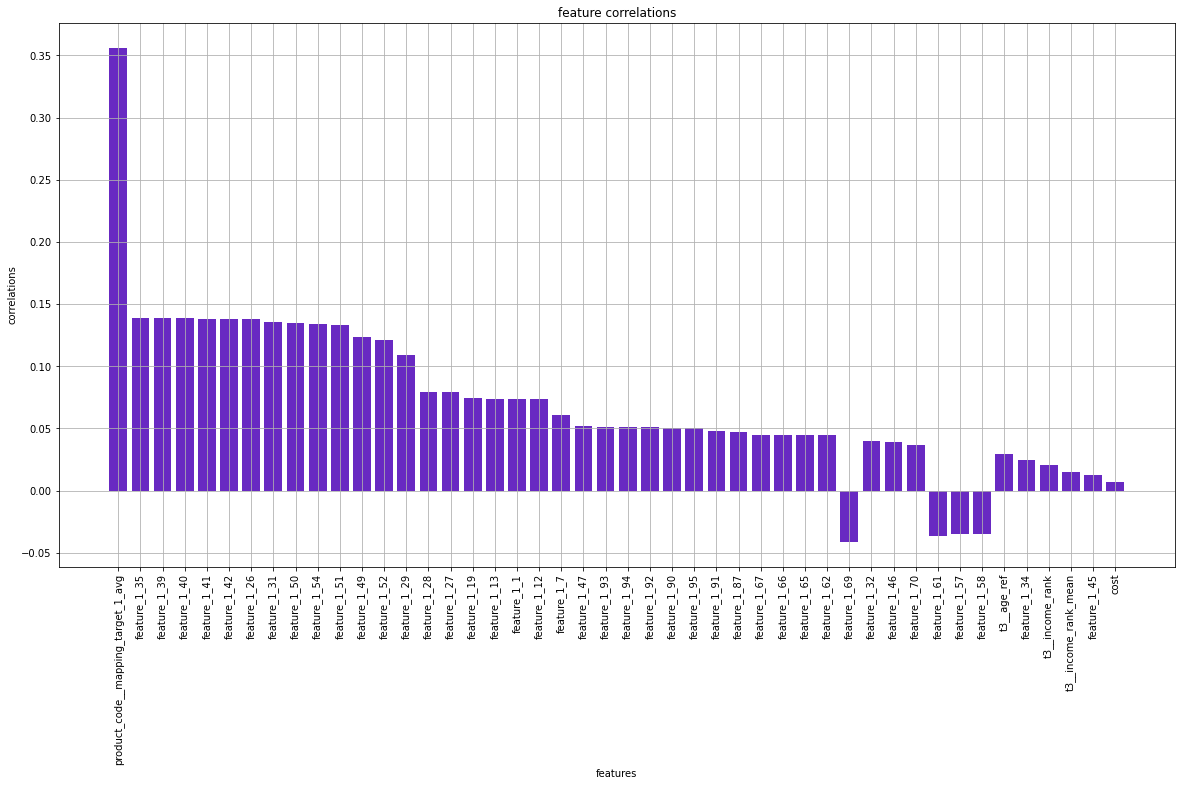

In [28]:
LENGTH=50

names, correlations = pipe1.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names[:LENGTH], correlations[:LENGTH], color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

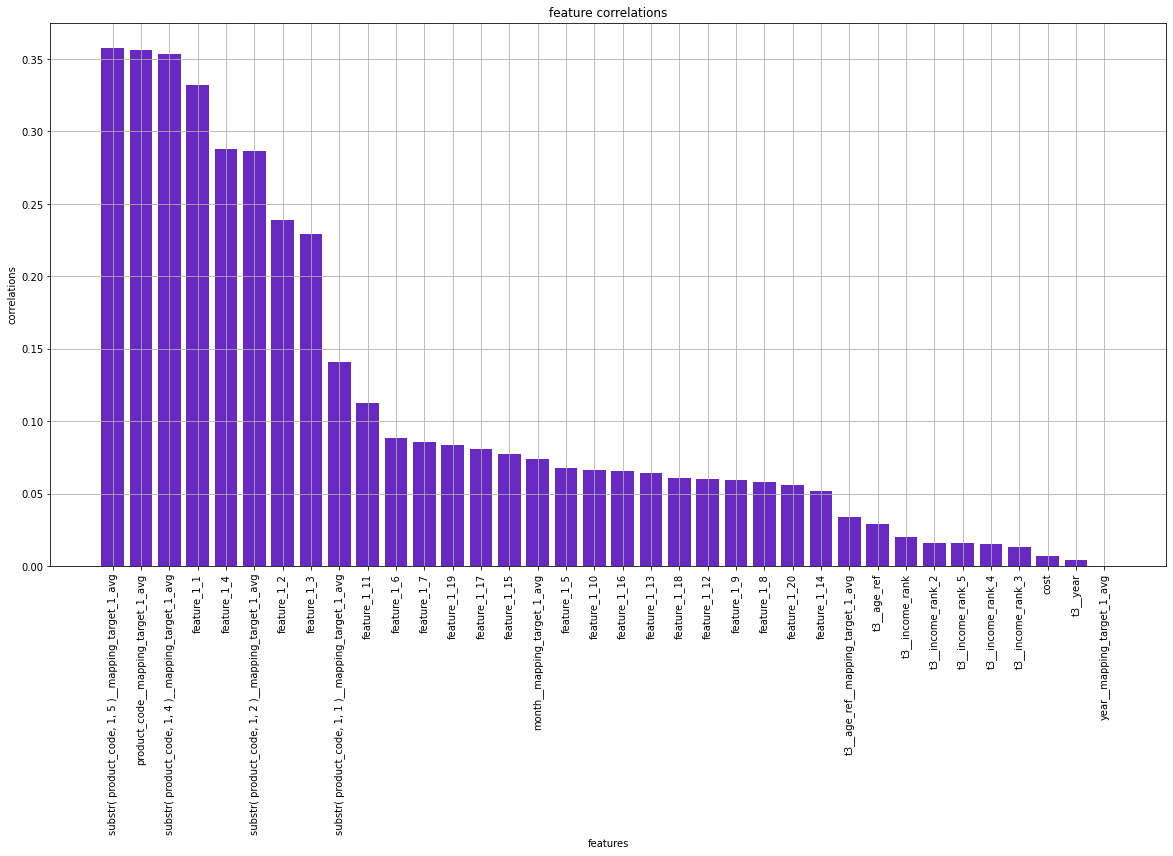

In [29]:
LENGTH=50

names, correlations = pipe2.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names[:LENGTH], correlations[:LENGTH], color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

We can express the features in SQLite3:

Because getML uses a feature learning approach, the concept of feature importances can also be carried over to the individual columns.

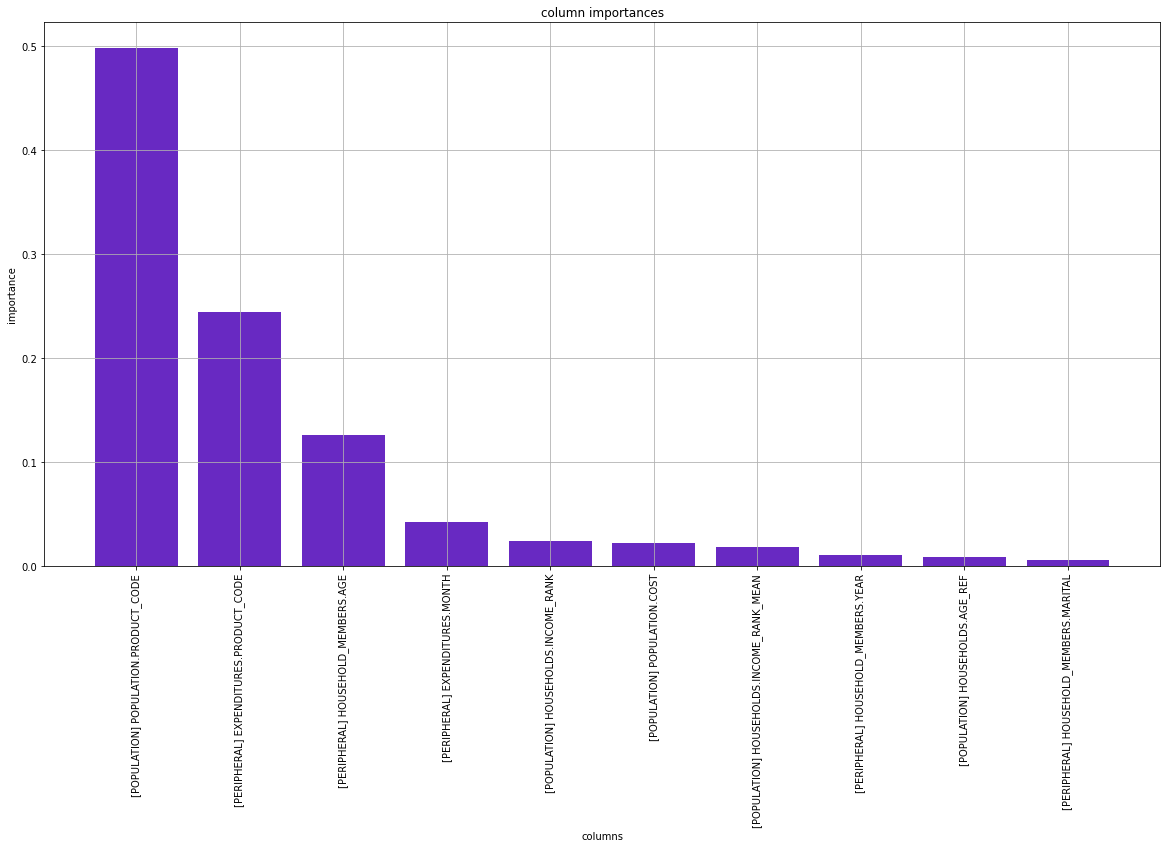

In [30]:
names, importances = pipe1.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

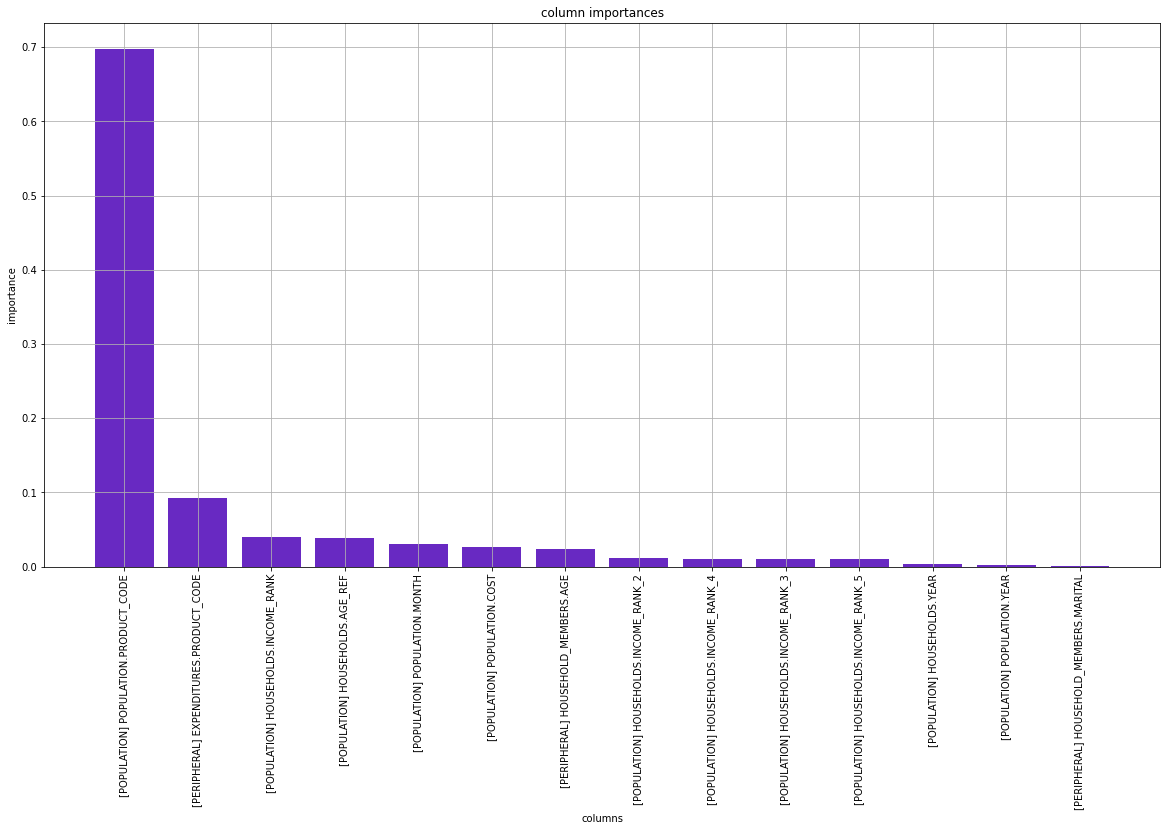

In [31]:
names, importances = pipe2.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title("column importances")
plt.grid(True)
plt.xlabel("columns")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

The most important features look as follows:

In [39]:
pipe1.features.to_sql()[pipe1.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "PRODUCT_CODE__MAPPING_TARGET_1_AVG";

CREATE TABLE "PRODUCT_CODE__MAPPING_TARGET_1_AVG"("key" TEXT, "value" REAL);

INSERT INTO "PRODUCT_CODE__MAPPING_TARGET_1_AVG" ("key", "value")
VALUES('410901', 0.5265553869499241),
      ('410140', 0.5248618784530387),
      ('004190', 0.5073846153846154),
      ('410120', 0.5013123359580053),
      ('410110', 0.4444444444444444),
      ('004100', 0.3336306868867083),
      ('390110', 0.3132530120481928),
      ('390120', 0.3067484662576687),
      ('410130', 0.2967448902346707),
      ('370110', 0.2948717948717949),
      ('370212', 0.2944444444444445),
      ('370220', 0.2920353982300885),
      ('680140', 0.288135593220339),
      ('390322', 0.2795918367346939),
      ('390321', 0.2764227642276423),
      ('370901', 0.271948608137045),
      ('390210', 0.2579837194740138),
      ('370125', 0.2519157088122606),
      ('390310', 0.2443181818181818),
      ('390223', 0.2344706911636046),
      ('390230', 0.2238442822384428),
      ('370211', 0.2185714285714286),
      ('370314', 0.2182952182952183),
      ('400220', 0.2164179104477612),
      ('610110', 0.2162868883078072),
      ('360320', 0.2151898734177215),
      ('590220', 0.2075471698113208),
      ('370213', 0.2015968063872255),
      ('400210', 0.1944764096662831),
      ('430120', 0.194006309148265),
      ('320130', 0.1899441340782123),
      ('390901', 0.1797752808988764),
      ('330410', 0.1751831107281344),
      ('380410', 0.1386392811296534),
      ('590230', 0.13469068128426),
      ('360350', 0.1321279554937413),
      ('360210', 0.1305555555555556),
      ('290420', 0.1282051282051282),
      ('280220', 0.1231884057971015),
      ('320903', 0.1229724632214259),
      ('360420', 0.1222091656874266),
      ('005000', 0.1219512195121951),
      ('660900', 0.1205479452054795),
      ('320345', 0.1176205497972059),
      ('610902', 0.1162790697674419),
      ('660110', 0.111731843575419),
      ('600900', 0.1111111111111111),
      ('670110', 0.1111111111111111),
      ('320233', 0.1108969866853539),
      ('610230', 0.11),
      ('660210', 0.1097922848664688),
      ('610901', 0.1097560975609756),
      ('380510', 0.1081081081081081),
      ('290310', 0.1044776119402985),
      ('280120', 0.1030640668523677),
      ('380901', 0.1010141987829615),
      ('320521', 0.1009174311926606),
      ('360330', 0.1004366812227074),
      ('360311', 0.09981167608286252),
      ('430110', 0.09863945578231292),
      ('300320', 0.0975609756097561),
      ('360312', 0.09716599190283401),
      ('660000', 0.09413886384129846),
      ('600430', 0.09302325581395349),
      ('380110', 0.09302325581395349),
      ('310231', 0.09090909090909091),
      ('004000', 0.08723998758149643),
      ('600410', 0.08408408408408409),
      ('310210', 0.08333333333333333),
      ('340120', 0.08333333333333333),
      ('430130', 0.08226221079691516),
      ('600210', 0.08190476190476191),
      ('380315', 0.08014981273408239),
      ('610120', 0.07865168539325842),
      ('620610', 0.07755102040816327),
      ('360513', 0.07722969606377678),
      ('280140', 0.07646356033452807),
      ('320380', 0.07645788336933046),
      ('620213', 0.07375643224699828),
      ('620510', 0.07370393504059962),
      ('380430', 0.07358390682901006),
      ('310316', 0.07329842931937172),
      ('310232', 0.0726950354609929),
      ('200210', 0.07258064516129033),
      ('530110', 0.07235621521335807),
      ('380320', 0.07142857142857142),
      ('640420', 0.06923076923076923),
      ('620214', 0.0689900426742532),
      ('610130', 0.06882591093117409),
      ('290410', 0.06748466257668712),
      ('380420', 0.06734816596512327),
      ('400310', 0.0672059738643435),
      ('690117', 0.06666666666666667),
      ('610903', 0.06578947368421052),
      ('310220', 0.06555863342566944),
      ('320330', 0.06554307116104868),
      ('400110', 0.06538692261547691),
      ('640120', 0.06442953020134229),
      ('690230', 0.0641025641025641),
      ('620330', 0.06329113924050633),
      ('420115', 0.06281407035175879),
      ('380311', 0.0625),
      ('310340', 0.06231454005934718),
      ('320370', 0.06196746707978312),
      ('380340', 0.06157635467980296),
      ('380210', 0.06014492753623189),
      ('620112', 0.05970149253731343),
      ('340110', 0.05929824561403509),
      ('320901', 0.05747126436781609),
      ('280110', 0.05726600985221675),
      ('290120', 0.05673758865248227),
      ('320150', 0.05652173913043478),
      ('240220', 0.05647840531561462),
      ('340907', 0.05555555555555555),
      ('600310', 0.05521472392638037),
      ('320221', 0.05381727158948686),
      ('320522', 0.05371900826446281),
      ('620913', 0.05333333333333334),
      ('340510', 0.052734375),
      ('640130', 0.05263157894736842),
      ('310332', 0.05128205128205128),
      ('320232', 0.05029013539651837),
      ('380333', 0.0501577287066246),
      ('690118', 0.05),
      ('670903', 0.04895104895104895),
      ('320905', 0.04766031195840555),
      ('320627', 0.04761904761904762),
      ('320902', 0.04666666666666667),
      ('690110', 0.04666666666666667),
      ('150110', 0.04635643740546312),
      ('620221', 0.04615384615384616),
      ('670901', 0.04597701149425287),
      ('001000', 0.04587155963302753),
      ('670310', 0.04553734061930783),
      ('340610', 0.04444444444444445),
      ('200410', 0.04397394136807817),
      ('300900', 0.04375),
      ('610320', 0.04300578034682081),
      ('300110', 0.0425531914893617),
      ('002000', 0.0418848167539267),
      ('680220', 0.04184704184704185),
      ('570901', 0.04081632653061224),
      ('280210', 0.04081632653061224),
      ('600420', 0.04044489383215369),
      ('320420', 0.0400890868596882),
      ('290440', 0.038860103626943),
      ('200310', 0.03872966692486444),
      ('310900', 0.0380952380952381),
      ('520550', 0.03773584905660377),
      ('690116', 0.03773584905660377),
      ('020410', 0.03773262762506403),
      ('440130', 0.03759398496240601),
      ('380902', 0.03571428571428571),
      ('550320', 0.03547297297297297),
      ('290110', 0.03539823008849557),
      ('590210', 0.03476151980598222),
      ('320904', 0.03454231433506045),
      ('490311', 0.03448275862068965),
      ('620310', 0.03422053231939164),
      ('220000', 0.03418803418803419),
      ('320120', 0.03355704697986577),
      ('240310', 0.03343949044585987),
      ('310351', 0.03333333333333333),
      ('640310', 0.03329679364209372),
      ('670902', 0.03174603174603174),
      ('680903', 0.03137789904502047),
      ('310140', 0.0308641975308642),
      ('620420', 0.03061224489795918),
      ('630220', 0.03052325581395349),
      ('330610', 0.03022860381636123),
      ('330510', 0.02971188475390156),
      ('180620', 0.02942668696093353),
      ('240900', 0.02941176470588235),
      ('550330', 0.02935420743639922),
      ('320610', 0.02929427430093209),
      ('620710', 0.02877697841726619),
      ('290320', 0.02877697841726619),
      ('200111', 0.02867072111207646),
      ('240320', 0.02842928216062544),
      ('310352', 0.02838427947598253),
      ('320410', 0.02791625124626122),
      ('300218', 0.02777777777777778),
      ('320110', 0.02768166089965398),
      ('620121', 0.02765208647561589),
      ('340210', 0.02722323049001815),
      ('240210', 0.02707581227436823),
      ('440150', 0.02702702702702703),
      ('320140', 0.02697022767075306),
      ('640220', 0.02683461117196057),
      ('640410', 0.026232741617357),
      ('310335', 0.02593659942363112),
      ('490315', 0.02564102564102564),
      ('340901', 0.02542372881355932),
      ('610310', 0.02461584365209608),
      ('680110', 0.02362204724409449),
      ('340903', 0.0234375),
      ('480213', 0.0231811697574893),
      ('320430', 0.02272727272727273),
      ('230000', 0.02272727272727273),
      ('640210', 0.02267002518891688),
      ('550310', 0.02246796559592768),
      ('490110', 0.02173913043478261),
      ('620410', 0.02165087956698241),
      ('340913', 0.02127659574468085),
      ('340906', 0.02127659574468085),
      ('590110', 0.0209366391184573),
      ('620810', 0.02090592334494774),
      ('020710', 0.02085600290170475),
      ('620926', 0.02076875387476751),
      ('480212', 0.02055622732769045),
      ('020510', 0.0202097074243193),
      ('650210', 0.02016868353502017),
      ('530510', 0.02005730659025788),
      ('520310', 0.02),
      ('480110', 0.01970443349753695),
      ('550110', 0.0194300518134715),
      ('650110', 0.0190424374319913),
      ('320511', 0.01829268292682927),
      ('240120', 0.01818181818181818),
      ('040610', 0.01785714285714286),
      ('170531', 0.0177293934681182),
      ('550210', 0.01761658031088083),
      ('290430', 0.01748251748251748),
      ('002100', 0.01715481171548117),
      ('150310', 0.01708217913204063),
      ('560310', 0.01682692307692308),
      ('640110', 0.01674500587544066),
      ('640430', 0.01648351648351648),
      ('570000', 0.01633393829401089),
      ('240110', 0.0162052667116813),
      ('690119', 0.01618122977346278),
      ('630110', 0.0158344666796192),
      ('330310', 0.01570146818923328),
      ('020820', 0.01567783584383646),
      ('130320', 0.0156165858912224),
      ('630210', 0.0155902004454343),
      ('020610', 0.01553829078801332),
      ('010120', 0.01547231270358306),
      ('180310', 0.01535880227155395),
      ('550410', 0.01529571719918423),
      ('360110', 0.01515151515151515),
      ('620114', 0.01492537313432836),
      ('440210', 0.01488095238095238),
      ('470220', 0.01478743068391867),
      ('620111', 0.01471389645776567),
      ('330210', 0.01441871961769795),
      ('140320', 0.01423487544483986),
      ('340520', 0.01411100658513641),
      ('560210', 0.01355661881977671),
      ('530311', 0.01341184167484462),
      ('330110', 0.01330895052321447),
      ('050900', 0.0131578947368421),
      ('250900', 0.01309707241910632),
      ('690120', 0.01305483028720627),
      ('490300', 0.01298701298701299),
      ('180320', 0.01298701298701299),
      ('170533', 0.01296982530439386),
      ('540000', 0.01271259233808624),
      ('170510', 0.01269971323228185),
      ('620930', 0.01252609603340292),
      ('340410', 0.01241642788920726),
      ('270000', 0.01241039905852145),
      ('520110', 0.01237964236588721),
      ('560400', 0.01210898082744702),
      ('180612', 0.01201452919810003),
      ('620320', 0.01185770750988142),
      ('470211', 0.01179941002949852),
      ('180520', 0.01179574732267577),
      ('100410', 0.01164329187615771),
      ('310331', 0.01162790697674419),
      ('530412', 0.01158504476040021),
      ('020810', 0.01154575219713941),
      ('530210', 0.01152737752161383),
      ('220110', 0.01149425287356322),
      ('320630', 0.01142857142857143),
      ('520531', 0.01112484548825711),
      ('180710', 0.01103708190322364),
      ('030810', 0.01092896174863388),
      ('130310', 0.01086556169429098),
      ('170210', 0.01082262080178853),
      ('340620', 0.01075268817204301),
      ('999900', 0.01062416998671979),
      ('030210', 0.01055662188099808),
      ('030510', 0.01044277360066834),
      ('170110', 0.01034780109226789),
      ('220210', 0.01027397260273973),
      ('680902', 0.01025641025641026),
      ('020310', 0.01021667580910587),
      ('130212', 0.009969657563935847),
      ('030710', 0.009891435464414958),
      ('140420', 0.009844993715961458),
      ('560330', 0.009771986970684038),
      ('270210', 0.009420631182289214),
      ('140220', 0.009351432880844645),
      ('160320', 0.00933609958506224),
      ('560110', 0.009322560596643879),
      ('170520', 0.009291360421578144),
      ('230110', 0.009202453987730062),
      ('170310', 0.009154113557358054),
      ('180110', 0.009134615384615385),
      ('140210', 0.009130282102305981),
      ('160212', 0.009098914000587027),
      ('050410', 0.008833922261484099),
      ('100210', 0.008741319144525446),
      ('170532', 0.008554705087798289),
      ('620912', 0.008553654743390357),
      ('090210', 0.008506616257088847),
      ('490000', 0.008489564909798374),
      ('170410', 0.008431932544539644),
      ('210210', 0.00823045267489712),
      ('020620', 0.008152173913043478),
      ('340310', 0.008032128514056224),
      ('110410', 0.007990834884720034),
      ('490312', 0.007977207977207978),
      ('210110', 0.007972665148063782),
      ('180420', 0.007866728366496992),
      ('180220', 0.007703887363853715),
      ('010210', 0.007637017070979336),
      ('180510', 0.007588713125267208),
      ('470111', 0.007556238768484639),
      ('060310', 0.007518796992481203),
      ('050310', 0.007514761137949544),
      ('030610', 0.007317073170731708),
      ('180611', 0.007287611061195967),
      ('010320', 0.007257694074414332),
      ('500110', 0.007106598984771574),
      ('040510', 0.006984459577440196),
      ('110310', 0.006973269134982567),
      ('250220', 0.006944444444444444),
      ('580000', 0.006857142857142857),
      ('020210', 0.006824146981627296),
      ('180210', 0.006806282722513089),
      ('040410', 0.006790744466800805),
      ('050110', 0.00675990675990676),
      ('010110', 0.006644518272425249),
      ('180410', 0.006634078212290503),
      ('140230', 0.00663265306122449),
      ('050210', 0.00662133142448103),
      ('160310', 0.006574892130675981),
      ('020110', 0.006501360749924402),
      ('070110', 0.006377551020408163),
      ('030310', 0.00625),
      ('120310', 0.006177540831006178),
      ('100510', 0.006119326874043855),
      ('030410', 0.006116207951070336),
      ('690114', 0.006105834464043419),
      ('110510', 0.005989518342899925),
      ('160211', 0.005981308411214953),
      ('150211', 0.005960568546538285),
      ('130211', 0.005947955390334572),
      ('520541', 0.005911778080945885),
      ('120210', 0.005798018131983976),
      ('040110', 0.005780346820809248),
      ('260110', 0.005772763054316453),
      ('070240', 0.005749668288367979),
      ('090110', 0.005704227647576519),
      ('110210', 0.005692403229145104),
      ('030110', 0.005622410731899783),
      ('260210', 0.0055542698449433),
      ('080110', 0.005548549810844893),
      ('120110', 0.005436931593515224),
      ('040310', 0.005404077622205846),
      ('250210', 0.005342831700801425),
      ('010310', 0.005331627212625293),
      ('440120', 0.005319148936170213),
      ('100110', 0.005308219178082192),
      ('470112', 0.005277044854881266),
      ('110110', 0.005152378864284149),
      ('160110', 0.005109489051094891),
      ('270410', 0.00496031746031746),
      ('060110', 0.004922542348342262),
      ('520516', 0.004901960784313725),
      ('270310', 0.004885574697865775),
      ('120410', 0.004865350089766607),
      ('220120', 0.004815409309791332),
      ('040210', 0.004786324786324786),
      ('070230', 0.004725554343874954),
      ('130110', 0.004694835680751174),
      ('140110', 0.004555336991406978),
      ('340530', 0.004530011325028313),
      ('060210', 0.00400114318376679),
      ('230900', 0.003992015968063872),
      ('520410', 0.003937007874015748),
      ('140340', 0.003897369275738876),
      ('490313', 0.003875968992248062),
      ('009000', 0.002952029520295203),
      ('350110', 0.002881844380403458),
      ('140330', 0.002380952380952381),
      ('130122', 0.002169197396963124),
      ('150212', 0.001451378809869376),
      ('130121', 0.001373626373626374),
      ('190323', 0.0009389671361502347),
      ('190311', 0.0008796003096193089),
      ('200532', 0.0005934718100890207),
      ('190312', 0.0005761198329252485),
      ('190314', 0.0004549590536851683),
      ('190324', 0.0004541326067211626),
      ('200522', 0.0004464285714285714),
      ('190212', 0.0004089793692629283),
      ('190114', 0.0003787878787878788),
      ('190112', 0.0003610760064993681),
      ('190322', 0.0002765869174388052),
      ('190211', 0.0002144925463840132),
      ('190111', 0.0002058036633052068),
      ('200512', 0.0001853911753800519),
      ('190321', 7.427213309566251e-05),
      ('440140', 0),
      ('200112', 0),
      ('620925', 0),
      ('250110', 0),
      ('200531', 0),
      ('310242', 0),
      ('600130', 0),
      ('580901', 0),
      ('200521', 0),
      ('490316', 0),
      ('200523', 0),
      ('190113', 0),
      ('310241', 0),
      ('550340', 0),
      ('450350', 0),
      ('190214', 0),
      ('300410', 0),
      ('530903', 0),
      ('200513', 0),
      ('140410', 0),
      ('002200', 0),
      ('630900', 0),
      ('680210', 0),
      ('290210', 0),
      ('140310', 0),
      ('200533', 0),
      ('440110', 0),
      ('190313', 0),
      ('190213', 0),
      ('270311', 0),
      ('270900', 0),
      ('200511', 0);

ALTER TABLE "POPULATION__STAGING_TABLE_1" ADD COLUMN "product_code__mapping_target_1_avg";

UPDATE "POPULATION__STAGING_TABLE_1" SET "product_code__mapping_target_1_avg" = 0.0;

UPDATE "POPULATION__STAGING_TABLE_1"
SET "product_code__mapping_target_1_avg" = t2."value"
FROM "PRODUCT_CODE__MAPPING_TARGET_1_AVG" AS t2
WHERE "POPULATION__STAGING_TABLE_1"."product_code" = t2."key";

DROP TABLE IF EXISTS "PRODUCT_CODE__MAPPING_TARGET_1_AVG";
```

In [35]:
pipe2.features.to_sql()[pipe2.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "PRODUCT_CODE__MAPPING_TARGET_1_AVG";

CREATE TABLE "PRODUCT_CODE__MAPPING_TARGET_1_AVG"("key" TEXT, "value" REAL);

INSERT INTO "PRODUCT_CODE__MAPPING_TARGET_1_AVG" ("key", "value")
VALUES('410901', 0.5265553869499241),
      ('410140', 0.5248618784530387),
      ('004190', 0.5073846153846154),
      ('410120', 0.5013123359580053),
      ('410110', 0.4444444444444444),
      ('004100', 0.3336306868867083),
      ('390110', 0.3132530120481928),
      ('390120', 0.3067484662576687),
      ('410130', 0.2967448902346707),
      ('370110', 0.2948717948717949),
      ('370212', 0.2944444444444445),
      ('370220', 0.2920353982300885),
      ('680140', 0.288135593220339),
      ('390322', 0.2795918367346939),
      ('390321', 0.2764227642276423),
      ('370901', 0.271948608137045),
      ('390210', 0.2579837194740138),
      ('370125', 0.2519157088122606),
      ('390310', 0.2443181818181818),
      ('390223', 0.2344706911636046),
      ('390230', 0.2238442822384428),
      ('370211', 0.2185714285714286),
      ('370314', 0.2182952182952183),
      ('400220', 0.2164179104477612),
      ('610110', 0.2162868883078072),
      ('360320', 0.2151898734177215),
      ('590220', 0.2075471698113208),
      ('370213', 0.2015968063872255),
      ('400210', 0.1944764096662831),
      ('430120', 0.194006309148265),
      ('320130', 0.1899441340782123),
      ('390901', 0.1797752808988764),
      ('330410', 0.1751831107281344),
      ('380410', 0.1386392811296534),
      ('590230', 0.13469068128426),
      ('360350', 0.1321279554937413),
      ('360210', 0.1305555555555556),
      ('290420', 0.1282051282051282),
      ('280220', 0.1231884057971015),
      ('320903', 0.1229724632214259),
      ('360420', 0.1222091656874266),
      ('005000', 0.1219512195121951),
      ('660900', 0.1205479452054795),
      ('320345', 0.1176205497972059),
      ('610902', 0.1162790697674419),
      ('660110', 0.111731843575419),
      ('600900', 0.1111111111111111),
      ('670110', 0.1111111111111111),
      ('320233', 0.1108969866853539),
      ('610230', 0.11),
      ('660210', 0.1097922848664688),
      ('610901', 0.1097560975609756),
      ('380510', 0.1081081081081081),
      ('290310', 0.1044776119402985),
      ('280120', 0.1030640668523677),
      ('380901', 0.1010141987829615),
      ('320521', 0.1009174311926606),
      ('360330', 0.1004366812227074),
      ('360311', 0.09981167608286252),
      ('430110', 0.09863945578231292),
      ('300320', 0.0975609756097561),
      ('360312', 0.09716599190283401),
      ('660000', 0.09413886384129846),
      ('600430', 0.09302325581395349),
      ('380110', 0.09302325581395349),
      ('310231', 0.09090909090909091),
      ('004000', 0.08723998758149643),
      ('600410', 0.08408408408408409),
      ('310210', 0.08333333333333333),
      ('340120', 0.08333333333333333),
      ('430130', 0.08226221079691516),
      ('600210', 0.08190476190476191),
      ('380315', 0.08014981273408239),
      ('610120', 0.07865168539325842),
      ('620610', 0.07755102040816327),
      ('360513', 0.07722969606377678),
      ('280140', 0.07646356033452807),
      ('320380', 0.07645788336933046),
      ('620213', 0.07375643224699828),
      ('620510', 0.07370393504059962),
      ('380430', 0.07358390682901006),
      ('310316', 0.07329842931937172),
      ('310232', 0.0726950354609929),
      ('200210', 0.07258064516129033),
      ('530110', 0.07235621521335807),
      ('380320', 0.07142857142857142),
      ('640420', 0.06923076923076923),
      ('620214', 0.0689900426742532),
      ('610130', 0.06882591093117409),
      ('290410', 0.06748466257668712),
      ('380420', 0.06734816596512327),
      ('400310', 0.0672059738643435),
      ('690117', 0.06666666666666667),
      ('610903', 0.06578947368421052),
      ('310220', 0.06555863342566944),
      ('320330', 0.06554307116104868),
      ('400110', 0.06538692261547691),
      ('640120', 0.06442953020134229),
      ('690230', 0.0641025641025641),
      ('620330', 0.06329113924050633),
      ('420115', 0.06281407035175879),
      ('380311', 0.0625),
      ('310340', 0.06231454005934718),
      ('320370', 0.06196746707978312),
      ('380340', 0.06157635467980296),
      ('380210', 0.06014492753623189),
      ('620112', 0.05970149253731343),
      ('340110', 0.05929824561403509),
      ('320901', 0.05747126436781609),
      ('280110', 0.05726600985221675),
      ('290120', 0.05673758865248227),
      ('320150', 0.05652173913043478),
      ('240220', 0.05647840531561462),
      ('340907', 0.05555555555555555),
      ('600310', 0.05521472392638037),
      ('320221', 0.05381727158948686),
      ('320522', 0.05371900826446281),
      ('620913', 0.05333333333333334),
      ('340510', 0.052734375),
      ('640130', 0.05263157894736842),
      ('310332', 0.05128205128205128),
      ('320232', 0.05029013539651837),
      ('380333', 0.0501577287066246),
      ('690118', 0.05),
      ('670903', 0.04895104895104895),
      ('320905', 0.04766031195840555),
      ('320627', 0.04761904761904762),
      ('320902', 0.04666666666666667),
      ('690110', 0.04666666666666667),
      ('150110', 0.04635643740546312),
      ('620221', 0.04615384615384616),
      ('670901', 0.04597701149425287),
      ('001000', 0.04587155963302753),
      ('670310', 0.04553734061930783),
      ('340610', 0.04444444444444445),
      ('200410', 0.04397394136807817),
      ('300900', 0.04375),
      ('610320', 0.04300578034682081),
      ('300110', 0.0425531914893617),
      ('002000', 0.0418848167539267),
      ('680220', 0.04184704184704185),
      ('570901', 0.04081632653061224),
      ('280210', 0.04081632653061224),
      ('600420', 0.04044489383215369),
      ('320420', 0.0400890868596882),
      ('290440', 0.038860103626943),
      ('200310', 0.03872966692486444),
      ('310900', 0.0380952380952381),
      ('520550', 0.03773584905660377),
      ('690116', 0.03773584905660377),
      ('020410', 0.03773262762506403),
      ('440130', 0.03759398496240601),
      ('380902', 0.03571428571428571),
      ('550320', 0.03547297297297297),
      ('290110', 0.03539823008849557),
      ('590210', 0.03476151980598222),
      ('320904', 0.03454231433506045),
      ('490311', 0.03448275862068965),
      ('620310', 0.03422053231939164),
      ('220000', 0.03418803418803419),
      ('320120', 0.03355704697986577),
      ('240310', 0.03343949044585987),
      ('310351', 0.03333333333333333),
      ('640310', 0.03329679364209372),
      ('670902', 0.03174603174603174),
      ('680903', 0.03137789904502047),
      ('310140', 0.0308641975308642),
      ('620420', 0.03061224489795918),
      ('630220', 0.03052325581395349),
      ('330610', 0.03022860381636123),
      ('330510', 0.02971188475390156),
      ('180620', 0.02942668696093353),
      ('240900', 0.02941176470588235),
      ('550330', 0.02935420743639922),
      ('320610', 0.02929427430093209),
      ('620710', 0.02877697841726619),
      ('290320', 0.02877697841726619),
      ('200111', 0.02867072111207646),
      ('240320', 0.02842928216062544),
      ('310352', 0.02838427947598253),
      ('320410', 0.02791625124626122),
      ('300218', 0.02777777777777778),
      ('320110', 0.02768166089965398),
      ('620121', 0.02765208647561589),
      ('340210', 0.02722323049001815),
      ('240210', 0.02707581227436823),
      ('440150', 0.02702702702702703),
      ('320140', 0.02697022767075306),
      ('640220', 0.02683461117196057),
      ('640410', 0.026232741617357),
      ('310335', 0.02593659942363112),
      ('490315', 0.02564102564102564),
      ('340901', 0.02542372881355932),
      ('610310', 0.02461584365209608),
      ('680110', 0.02362204724409449),
      ('340903', 0.0234375),
      ('480213', 0.0231811697574893),
      ('320430', 0.02272727272727273),
      ('230000', 0.02272727272727273),
      ('640210', 0.02267002518891688),
      ('550310', 0.02246796559592768),
      ('490110', 0.02173913043478261),
      ('620410', 0.02165087956698241),
      ('340913', 0.02127659574468085),
      ('340906', 0.02127659574468085),
      ('590110', 0.0209366391184573),
      ('620810', 0.02090592334494774),
      ('020710', 0.02085600290170475),
      ('620926', 0.02076875387476751),
      ('480212', 0.02055622732769045),
      ('020510', 0.0202097074243193),
      ('650210', 0.02016868353502017),
      ('530510', 0.02005730659025788),
      ('520310', 0.02),
      ('480110', 0.01970443349753695),
      ('550110', 0.0194300518134715),
      ('650110', 0.0190424374319913),
      ('320511', 0.01829268292682927),
      ('240120', 0.01818181818181818),
      ('040610', 0.01785714285714286),
      ('170531', 0.0177293934681182),
      ('550210', 0.01761658031088083),
      ('290430', 0.01748251748251748),
      ('002100', 0.01715481171548117),
      ('150310', 0.01708217913204063),
      ('560310', 0.01682692307692308),
      ('640110', 0.01674500587544066),
      ('640430', 0.01648351648351648),
      ('570000', 0.01633393829401089),
      ('240110', 0.0162052667116813),
      ('690119', 0.01618122977346278),
      ('630110', 0.0158344666796192),
      ('330310', 0.01570146818923328),
      ('020820', 0.01567783584383646),
      ('130320', 0.0156165858912224),
      ('630210', 0.0155902004454343),
      ('020610', 0.01553829078801332),
      ('010120', 0.01547231270358306),
      ('180310', 0.01535880227155395),
      ('550410', 0.01529571719918423),
      ('360110', 0.01515151515151515),
      ('620114', 0.01492537313432836),
      ('440210', 0.01488095238095238),
      ('470220', 0.01478743068391867),
      ('620111', 0.01471389645776567),
      ('330210', 0.01441871961769795),
      ('140320', 0.01423487544483986),
      ('340520', 0.01411100658513641),
      ('560210', 0.01355661881977671),
      ('530311', 0.01341184167484462),
      ('330110', 0.01330895052321447),
      ('050900', 0.0131578947368421),
      ('250900', 0.01309707241910632),
      ('690120', 0.01305483028720627),
      ('490300', 0.01298701298701299),
      ('180320', 0.01298701298701299),
      ('170533', 0.01296982530439386),
      ('540000', 0.01271259233808624),
      ('170510', 0.01269971323228185),
      ('620930', 0.01252609603340292),
      ('340410', 0.01241642788920726),
      ('270000', 0.01241039905852145),
      ('520110', 0.01237964236588721),
      ('560400', 0.01210898082744702),
      ('180612', 0.01201452919810003),
      ('620320', 0.01185770750988142),
      ('470211', 0.01179941002949852),
      ('180520', 0.01179574732267577),
      ('100410', 0.01164329187615771),
      ('310331', 0.01162790697674419),
      ('530412', 0.01158504476040021),
      ('020810', 0.01154575219713941),
      ('530210', 0.01152737752161383),
      ('220110', 0.01149425287356322),
      ('320630', 0.01142857142857143),
      ('520531', 0.01112484548825711),
      ('180710', 0.01103708190322364),
      ('030810', 0.01092896174863388),
      ('130310', 0.01086556169429098),
      ('170210', 0.01082262080178853),
      ('340620', 0.01075268817204301),
      ('999900', 0.01062416998671979),
      ('030210', 0.01055662188099808),
      ('030510', 0.01044277360066834),
      ('170110', 0.01034780109226789),
      ('220210', 0.01027397260273973),
      ('680902', 0.01025641025641026),
      ('020310', 0.01021667580910587),
      ('130212', 0.009969657563935847),
      ('030710', 0.009891435464414958),
      ('140420', 0.009844993715961458),
      ('560330', 0.009771986970684038),
      ('270210', 0.009420631182289214),
      ('140220', 0.009351432880844645),
      ('160320', 0.00933609958506224),
      ('560110', 0.009322560596643879),
      ('170520', 0.009291360421578144),
      ('230110', 0.009202453987730062),
      ('170310', 0.009154113557358054),
      ('180110', 0.009134615384615385),
      ('140210', 0.009130282102305981),
      ('160212', 0.009098914000587027),
      ('050410', 0.008833922261484099),
      ('100210', 0.008741319144525446),
      ('170532', 0.008554705087798289),
      ('620912', 0.008553654743390357),
      ('090210', 0.008506616257088847),
      ('490000', 0.008489564909798374),
      ('170410', 0.008431932544539644),
      ('210210', 0.00823045267489712),
      ('020620', 0.008152173913043478),
      ('340310', 0.008032128514056224),
      ('110410', 0.007990834884720034),
      ('490312', 0.007977207977207978),
      ('210110', 0.007972665148063782),
      ('180420', 0.007866728366496992),
      ('180220', 0.007703887363853715),
      ('010210', 0.007637017070979336),
      ('180510', 0.007588713125267208),
      ('470111', 0.007556238768484639),
      ('060310', 0.007518796992481203),
      ('050310', 0.007514761137949544),
      ('030610', 0.007317073170731708),
      ('180611', 0.007287611061195967),
      ('010320', 0.007257694074414332),
      ('500110', 0.007106598984771574),
      ('040510', 0.006984459577440196),
      ('110310', 0.006973269134982567),
      ('250220', 0.006944444444444444),
      ('580000', 0.006857142857142857),
      ('020210', 0.006824146981627296),
      ('180210', 0.006806282722513089),
      ('040410', 0.006790744466800805),
      ('050110', 0.00675990675990676),
      ('010110', 0.006644518272425249),
      ('180410', 0.006634078212290503),
      ('140230', 0.00663265306122449),
      ('050210', 0.00662133142448103),
      ('160310', 0.006574892130675981),
      ('020110', 0.006501360749924402),
      ('070110', 0.006377551020408163),
      ('030310', 0.00625),
      ('120310', 0.006177540831006178),
      ('100510', 0.006119326874043855),
      ('030410', 0.006116207951070336),
      ('690114', 0.006105834464043419),
      ('110510', 0.005989518342899925),
      ('160211', 0.005981308411214953),
      ('150211', 0.005960568546538285),
      ('130211', 0.005947955390334572),
      ('520541', 0.005911778080945885),
      ('120210', 0.005798018131983976),
      ('040110', 0.005780346820809248),
      ('260110', 0.005772763054316453),
      ('070240', 0.005749668288367979),
      ('090110', 0.005704227647576519),
      ('110210', 0.005692403229145104),
      ('030110', 0.005622410731899783),
      ('260210', 0.0055542698449433),
      ('080110', 0.005548549810844893),
      ('120110', 0.005436931593515224),
      ('040310', 0.005404077622205846),
      ('250210', 0.005342831700801425),
      ('010310', 0.005331627212625293),
      ('440120', 0.005319148936170213),
      ('100110', 0.005308219178082192),
      ('470112', 0.005277044854881266),
      ('110110', 0.005152378864284149),
      ('160110', 0.005109489051094891),
      ('270410', 0.00496031746031746),
      ('060110', 0.004922542348342262),
      ('520516', 0.004901960784313725),
      ('270310', 0.004885574697865775),
      ('120410', 0.004865350089766607),
      ('220120', 0.004815409309791332),
      ('040210', 0.004786324786324786),
      ('070230', 0.004725554343874954),
      ('130110', 0.004694835680751174),
      ('140110', 0.004555336991406978),
      ('340530', 0.004530011325028313),
      ('060210', 0.00400114318376679),
      ('230900', 0.003992015968063872),
      ('520410', 0.003937007874015748),
      ('140340', 0.003897369275738876),
      ('490313', 0.003875968992248062),
      ('009000', 0.002952029520295203),
      ('350110', 0.002881844380403458),
      ('140330', 0.002380952380952381),
      ('130122', 0.002169197396963124),
      ('150212', 0.001451378809869376),
      ('130121', 0.001373626373626374),
      ('190323', 0.0009389671361502347),
      ('190311', 0.0008796003096193089),
      ('200532', 0.0005934718100890207),
      ('190312', 0.0005761198329252485),
      ('190314', 0.0004549590536851683),
      ('190324', 0.0004541326067211626),
      ('200522', 0.0004464285714285714),
      ('190212', 0.0004089793692629283),
      ('190114', 0.0003787878787878788),
      ('190112', 0.0003610760064993681),
      ('190322', 0.0002765869174388052),
      ('190211', 0.0002144925463840132),
      ('190111', 0.0002058036633052068),
      ('200512', 0.0001853911753800519),
      ('190321', 7.427213309566251e-05),
      ('440140', 0),
      ('200112', 0),
      ('620925', 0),
      ('250110', 0),
      ('200531', 0),
      ('310242', 0),
      ('600130', 0),
      ('580901', 0),
      ('200521', 0),
      ('490316', 0),
      ('200523', 0),
      ('190113', 0),
      ('310241', 0),
      ('550340', 0),
      ('450350', 0),
      ('190214', 0),
      ('300410', 0),
      ('530903', 0),
      ('200513', 0),
      ('140410', 0),
      ('002200', 0),
      ('630900', 0),
      ('680210', 0),
      ('290210', 0),
      ('140310', 0),
      ('200533', 0),
      ('440110', 0),
      ('190313', 0),
      ('190213', 0),
      ('270311', 0),
      ('270900', 0),
      ('200511', 0);

ALTER TABLE "POPULATION__STAGING_TABLE_1" ADD COLUMN "product_code__mapping_target_1_avg";

UPDATE "POPULATION__STAGING_TABLE_1" SET "product_code__mapping_target_1_avg" = 0.0;

UPDATE "POPULATION__STAGING_TABLE_1"
SET "product_code__mapping_target_1_avg" = t2."value"
FROM "PRODUCT_CODE__MAPPING_TARGET_1_AVG" AS t2
WHERE "POPULATION__STAGING_TABLE_1"."product_code" = t2."key";

DROP TABLE IF EXISTS "PRODUCT_CODE__MAPPING_TARGET_1_AVG";
```

In [36]:
pipe3.features.to_sql()[pipe3.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "PRODUCT_CODE__MAPPING_TARGET_1_AVG";

CREATE TABLE "PRODUCT_CODE__MAPPING_TARGET_1_AVG"("key" TEXT, "value" REAL);

INSERT INTO "PRODUCT_CODE__MAPPING_TARGET_1_AVG" ("key", "value")
VALUES('410901', 0.5265553869499241),
      ('410140', 0.5248618784530387),
      ('004190', 0.5073846153846154),
      ('410120', 0.5013123359580053),
      ('410110', 0.4444444444444444),
      ('004100', 0.3336306868867083),
      ('390110', 0.3132530120481928),
      ('390120', 0.3067484662576687),
      ('410130', 0.2967448902346707),
      ('370110', 0.2948717948717949),
      ('370212', 0.2944444444444445),
      ('370220', 0.2920353982300885),
      ('680140', 0.288135593220339),
      ('390322', 0.2795918367346939),
      ('390321', 0.2764227642276423),
      ('370901', 0.271948608137045),
      ('390210', 0.2579837194740138),
      ('370125', 0.2519157088122606),
      ('390310', 0.2443181818181818),
      ('390223', 0.2344706911636046),
      ('390230', 0.2238442822384428),
      ('370211', 0.2185714285714286),
      ('370314', 0.2182952182952183),
      ('400220', 0.2164179104477612),
      ('610110', 0.2162868883078072),
      ('360320', 0.2151898734177215),
      ('590220', 0.2075471698113208),
      ('370213', 0.2015968063872255),
      ('400210', 0.1944764096662831),
      ('430120', 0.194006309148265),
      ('320130', 0.1899441340782123),
      ('390901', 0.1797752808988764),
      ('330410', 0.1751831107281344),
      ('380410', 0.1386392811296534),
      ('590230', 0.13469068128426),
      ('360350', 0.1321279554937413),
      ('360210', 0.1305555555555556),
      ('290420', 0.1282051282051282),
      ('280220', 0.1231884057971015),
      ('320903', 0.1229724632214259),
      ('360420', 0.1222091656874266),
      ('005000', 0.1219512195121951),
      ('660900', 0.1205479452054795),
      ('320345', 0.1176205497972059),
      ('610902', 0.1162790697674419),
      ('660110', 0.111731843575419),
      ('600900', 0.1111111111111111),
      ('670110', 0.1111111111111111),
      ('320233', 0.1108969866853539),
      ('610230', 0.11),
      ('660210', 0.1097922848664688),
      ('610901', 0.1097560975609756),
      ('380510', 0.1081081081081081),
      ('290310', 0.1044776119402985),
      ('280120', 0.1030640668523677),
      ('380901', 0.1010141987829615),
      ('320521', 0.1009174311926606),
      ('360330', 0.1004366812227074),
      ('360311', 0.09981167608286252),
      ('430110', 0.09863945578231292),
      ('300320', 0.0975609756097561),
      ('360312', 0.09716599190283401),
      ('660000', 0.09413886384129846),
      ('600430', 0.09302325581395349),
      ('380110', 0.09302325581395349),
      ('310231', 0.09090909090909091),
      ('004000', 0.08723998758149643),
      ('600410', 0.08408408408408409),
      ('310210', 0.08333333333333333),
      ('340120', 0.08333333333333333),
      ('430130', 0.08226221079691516),
      ('600210', 0.08190476190476191),
      ('380315', 0.08014981273408239),
      ('610120', 0.07865168539325842),
      ('620610', 0.07755102040816327),
      ('360513', 0.07722969606377678),
      ('280140', 0.07646356033452807),
      ('320380', 0.07645788336933046),
      ('620213', 0.07375643224699828),
      ('620510', 0.07370393504059962),
      ('380430', 0.07358390682901006),
      ('310316', 0.07329842931937172),
      ('310232', 0.0726950354609929),
      ('200210', 0.07258064516129033),
      ('530110', 0.07235621521335807),
      ('380320', 0.07142857142857142),
      ('640420', 0.06923076923076923),
      ('620214', 0.0689900426742532),
      ('610130', 0.06882591093117409),
      ('290410', 0.06748466257668712),
      ('380420', 0.06734816596512327),
      ('400310', 0.0672059738643435),
      ('690117', 0.06666666666666667),
      ('610903', 0.06578947368421052),
      ('310220', 0.06555863342566944),
      ('320330', 0.06554307116104868),
      ('400110', 0.06538692261547691),
      ('640120', 0.06442953020134229),
      ('690230', 0.0641025641025641),
      ('620330', 0.06329113924050633),
      ('420115', 0.06281407035175879),
      ('380311', 0.0625),
      ('310340', 0.06231454005934718),
      ('320370', 0.06196746707978312),
      ('380340', 0.06157635467980296),
      ('380210', 0.06014492753623189),
      ('620112', 0.05970149253731343),
      ('340110', 0.05929824561403509),
      ('320901', 0.05747126436781609),
      ('280110', 0.05726600985221675),
      ('290120', 0.05673758865248227),
      ('320150', 0.05652173913043478),
      ('240220', 0.05647840531561462),
      ('340907', 0.05555555555555555),
      ('600310', 0.05521472392638037),
      ('320221', 0.05381727158948686),
      ('320522', 0.05371900826446281),
      ('620913', 0.05333333333333334),
      ('340510', 0.052734375),
      ('640130', 0.05263157894736842),
      ('310332', 0.05128205128205128),
      ('320232', 0.05029013539651837),
      ('380333', 0.0501577287066246),
      ('690118', 0.05),
      ('670903', 0.04895104895104895),
      ('320905', 0.04766031195840555),
      ('320627', 0.04761904761904762),
      ('320902', 0.04666666666666667),
      ('690110', 0.04666666666666667),
      ('150110', 0.04635643740546312),
      ('620221', 0.04615384615384616),
      ('670901', 0.04597701149425287),
      ('001000', 0.04587155963302753),
      ('670310', 0.04553734061930783),
      ('340610', 0.04444444444444445),
      ('200410', 0.04397394136807817),
      ('300900', 0.04375),
      ('610320', 0.04300578034682081),
      ('300110', 0.0425531914893617),
      ('002000', 0.0418848167539267),
      ('680220', 0.04184704184704185),
      ('570901', 0.04081632653061224),
      ('280210', 0.04081632653061224),
      ('600420', 0.04044489383215369),
      ('320420', 0.0400890868596882),
      ('290440', 0.038860103626943),
      ('200310', 0.03872966692486444),
      ('310900', 0.0380952380952381),
      ('520550', 0.03773584905660377),
      ('690116', 0.03773584905660377),
      ('020410', 0.03773262762506403),
      ('440130', 0.03759398496240601),
      ('380902', 0.03571428571428571),
      ('550320', 0.03547297297297297),
      ('290110', 0.03539823008849557),
      ('590210', 0.03476151980598222),
      ('320904', 0.03454231433506045),
      ('490311', 0.03448275862068965),
      ('620310', 0.03422053231939164),
      ('220000', 0.03418803418803419),
      ('320120', 0.03355704697986577),
      ('240310', 0.03343949044585987),
      ('310351', 0.03333333333333333),
      ('640310', 0.03329679364209372),
      ('670902', 0.03174603174603174),
      ('680903', 0.03137789904502047),
      ('310140', 0.0308641975308642),
      ('620420', 0.03061224489795918),
      ('630220', 0.03052325581395349),
      ('330610', 0.03022860381636123),
      ('330510', 0.02971188475390156),
      ('180620', 0.02942668696093353),
      ('240900', 0.02941176470588235),
      ('550330', 0.02935420743639922),
      ('320610', 0.02929427430093209),
      ('620710', 0.02877697841726619),
      ('290320', 0.02877697841726619),
      ('200111', 0.02867072111207646),
      ('240320', 0.02842928216062544),
      ('310352', 0.02838427947598253),
      ('320410', 0.02791625124626122),
      ('300218', 0.02777777777777778),
      ('320110', 0.02768166089965398),
      ('620121', 0.02765208647561589),
      ('340210', 0.02722323049001815),
      ('240210', 0.02707581227436823),
      ('440150', 0.02702702702702703),
      ('320140', 0.02697022767075306),
      ('640220', 0.02683461117196057),
      ('640410', 0.026232741617357),
      ('310335', 0.02593659942363112),
      ('490315', 0.02564102564102564),
      ('340901', 0.02542372881355932),
      ('610310', 0.02461584365209608),
      ('680110', 0.02362204724409449),
      ('340903', 0.0234375),
      ('480213', 0.0231811697574893),
      ('320430', 0.02272727272727273),
      ('230000', 0.02272727272727273),
      ('640210', 0.02267002518891688),
      ('550310', 0.02246796559592768),
      ('490110', 0.02173913043478261),
      ('620410', 0.02165087956698241),
      ('340913', 0.02127659574468085),
      ('340906', 0.02127659574468085),
      ('590110', 0.0209366391184573),
      ('620810', 0.02090592334494774),
      ('020710', 0.02085600290170475),
      ('620926', 0.02076875387476751),
      ('480212', 0.02055622732769045),
      ('020510', 0.0202097074243193),
      ('650210', 0.02016868353502017),
      ('530510', 0.02005730659025788),
      ('520310', 0.02),
      ('480110', 0.01970443349753695),
      ('550110', 0.0194300518134715),
      ('650110', 0.0190424374319913),
      ('320511', 0.01829268292682927),
      ('240120', 0.01818181818181818),
      ('040610', 0.01785714285714286),
      ('170531', 0.0177293934681182),
      ('550210', 0.01761658031088083),
      ('290430', 0.01748251748251748),
      ('002100', 0.01715481171548117),
      ('150310', 0.01708217913204063),
      ('560310', 0.01682692307692308),
      ('640110', 0.01674500587544066),
      ('640430', 0.01648351648351648),
      ('570000', 0.01633393829401089),
      ('240110', 0.0162052667116813),
      ('690119', 0.01618122977346278),
      ('630110', 0.0158344666796192),
      ('330310', 0.01570146818923328),
      ('020820', 0.01567783584383646),
      ('130320', 0.0156165858912224),
      ('630210', 0.0155902004454343),
      ('020610', 0.01553829078801332),
      ('010120', 0.01547231270358306),
      ('180310', 0.01535880227155395),
      ('550410', 0.01529571719918423),
      ('360110', 0.01515151515151515),
      ('620114', 0.01492537313432836),
      ('440210', 0.01488095238095238),
      ('470220', 0.01478743068391867),
      ('620111', 0.01471389645776567),
      ('330210', 0.01441871961769795),
      ('140320', 0.01423487544483986),
      ('340520', 0.01411100658513641),
      ('560210', 0.01355661881977671),
      ('530311', 0.01341184167484462),
      ('330110', 0.01330895052321447),
      ('050900', 0.0131578947368421),
      ('250900', 0.01309707241910632),
      ('690120', 0.01305483028720627),
      ('490300', 0.01298701298701299),
      ('180320', 0.01298701298701299),
      ('170533', 0.01296982530439386),
      ('540000', 0.01271259233808624),
      ('170510', 0.01269971323228185),
      ('620930', 0.01252609603340292),
      ('340410', 0.01241642788920726),
      ('270000', 0.01241039905852145),
      ('520110', 0.01237964236588721),
      ('560400', 0.01210898082744702),
      ('180612', 0.01201452919810003),
      ('620320', 0.01185770750988142),
      ('470211', 0.01179941002949852),
      ('180520', 0.01179574732267577),
      ('100410', 0.01164329187615771),
      ('310331', 0.01162790697674419),
      ('530412', 0.01158504476040021),
      ('020810', 0.01154575219713941),
      ('530210', 0.01152737752161383),
      ('220110', 0.01149425287356322),
      ('320630', 0.01142857142857143),
      ('520531', 0.01112484548825711),
      ('180710', 0.01103708190322364),
      ('030810', 0.01092896174863388),
      ('130310', 0.01086556169429098),
      ('170210', 0.01082262080178853),
      ('340620', 0.01075268817204301),
      ('999900', 0.01062416998671979),
      ('030210', 0.01055662188099808),
      ('030510', 0.01044277360066834),
      ('170110', 0.01034780109226789),
      ('220210', 0.01027397260273973),
      ('680902', 0.01025641025641026),
      ('020310', 0.01021667580910587),
      ('130212', 0.009969657563935847),
      ('030710', 0.009891435464414958),
      ('140420', 0.009844993715961458),
      ('560330', 0.009771986970684038),
      ('270210', 0.009420631182289214),
      ('140220', 0.009351432880844645),
      ('160320', 0.00933609958506224),
      ('560110', 0.009322560596643879),
      ('170520', 0.009291360421578144),
      ('230110', 0.009202453987730062),
      ('170310', 0.009154113557358054),
      ('180110', 0.009134615384615385),
      ('140210', 0.009130282102305981),
      ('160212', 0.009098914000587027),
      ('050410', 0.008833922261484099),
      ('100210', 0.008741319144525446),
      ('170532', 0.008554705087798289),
      ('620912', 0.008553654743390357),
      ('090210', 0.008506616257088847),
      ('490000', 0.008489564909798374),
      ('170410', 0.008431932544539644),
      ('210210', 0.00823045267489712),
      ('020620', 0.008152173913043478),
      ('340310', 0.008032128514056224),
      ('110410', 0.007990834884720034),
      ('490312', 0.007977207977207978),
      ('210110', 0.007972665148063782),
      ('180420', 0.007866728366496992),
      ('180220', 0.007703887363853715),
      ('010210', 0.007637017070979336),
      ('180510', 0.007588713125267208),
      ('470111', 0.007556238768484639),
      ('060310', 0.007518796992481203),
      ('050310', 0.007514761137949544),
      ('030610', 0.007317073170731708),
      ('180611', 0.007287611061195967),
      ('010320', 0.007257694074414332),
      ('500110', 0.007106598984771574),
      ('040510', 0.006984459577440196),
      ('110310', 0.006973269134982567),
      ('250220', 0.006944444444444444),
      ('580000', 0.006857142857142857),
      ('020210', 0.006824146981627296),
      ('180210', 0.006806282722513089),
      ('040410', 0.006790744466800805),
      ('050110', 0.00675990675990676),
      ('010110', 0.006644518272425249),
      ('180410', 0.006634078212290503),
      ('140230', 0.00663265306122449),
      ('050210', 0.00662133142448103),
      ('160310', 0.006574892130675981),
      ('020110', 0.006501360749924402),
      ('070110', 0.006377551020408163),
      ('030310', 0.00625),
      ('120310', 0.006177540831006178),
      ('100510', 0.006119326874043855),
      ('030410', 0.006116207951070336),
      ('690114', 0.006105834464043419),
      ('110510', 0.005989518342899925),
      ('160211', 0.005981308411214953),
      ('150211', 0.005960568546538285),
      ('130211', 0.005947955390334572),
      ('520541', 0.005911778080945885),
      ('120210', 0.005798018131983976),
      ('040110', 0.005780346820809248),
      ('260110', 0.005772763054316453),
      ('070240', 0.005749668288367979),
      ('090110', 0.005704227647576519),
      ('110210', 0.005692403229145104),
      ('030110', 0.005622410731899783),
      ('260210', 0.0055542698449433),
      ('080110', 0.005548549810844893),
      ('120110', 0.005436931593515224),
      ('040310', 0.005404077622205846),
      ('250210', 0.005342831700801425),
      ('010310', 0.005331627212625293),
      ('440120', 0.005319148936170213),
      ('100110', 0.005308219178082192),
      ('470112', 0.005277044854881266),
      ('110110', 0.005152378864284149),
      ('160110', 0.005109489051094891),
      ('270410', 0.00496031746031746),
      ('060110', 0.004922542348342262),
      ('520516', 0.004901960784313725),
      ('270310', 0.004885574697865775),
      ('120410', 0.004865350089766607),
      ('220120', 0.004815409309791332),
      ('040210', 0.004786324786324786),
      ('070230', 0.004725554343874954),
      ('130110', 0.004694835680751174),
      ('140110', 0.004555336991406978),
      ('340530', 0.004530011325028313),
      ('060210', 0.00400114318376679),
      ('230900', 0.003992015968063872),
      ('520410', 0.003937007874015748),
      ('140340', 0.003897369275738876),
      ('490313', 0.003875968992248062),
      ('009000', 0.002952029520295203),
      ('350110', 0.002881844380403458),
      ('140330', 0.002380952380952381),
      ('130122', 0.002169197396963124),
      ('150212', 0.001451378809869376),
      ('130121', 0.001373626373626374),
      ('190323', 0.0009389671361502347),
      ('190311', 0.0008796003096193089),
      ('200532', 0.0005934718100890207),
      ('190312', 0.0005761198329252485),
      ('190314', 0.0004549590536851683),
      ('190324', 0.0004541326067211626),
      ('200522', 0.0004464285714285714),
      ('190212', 0.0004089793692629283),
      ('190114', 0.0003787878787878788),
      ('190112', 0.0003610760064993681),
      ('190322', 0.0002765869174388052),
      ('190211', 0.0002144925463840132),
      ('190111', 0.0002058036633052068),
      ('200512', 0.0001853911753800519),
      ('190321', 7.427213309566251e-05),
      ('440140', 0),
      ('200112', 0),
      ('620925', 0),
      ('250110', 0),
      ('200531', 0),
      ('310242', 0),
      ('600130', 0),
      ('580901', 0),
      ('200521', 0),
      ('490316', 0),
      ('200523', 0),
      ('190113', 0),
      ('310241', 0),
      ('550340', 0),
      ('450350', 0),
      ('190214', 0),
      ('300410', 0),
      ('530903', 0),
      ('200513', 0),
      ('140410', 0),
      ('002200', 0),
      ('630900', 0),
      ('680210', 0),
      ('290210', 0),
      ('140310', 0),
      ('200533', 0),
      ('440110', 0),
      ('190313', 0),
      ('190213', 0),
      ('270311', 0),
      ('270900', 0),
      ('200511', 0);

ALTER TABLE "POPULATION__STAGING_TABLE_1" ADD COLUMN "product_code__mapping_target_1_avg";

UPDATE "POPULATION__STAGING_TABLE_1" SET "product_code__mapping_target_1_avg" = 0.0;

UPDATE "POPULATION__STAGING_TABLE_1"
SET "product_code__mapping_target_1_avg" = t2."value"
FROM "PRODUCT_CODE__MAPPING_TARGET_1_AVG" AS t2
WHERE "POPULATION__STAGING_TABLE_1"."product_code" = t2."key";

DROP TABLE IF EXISTS "PRODUCT_CODE__MAPPING_TARGET_1_AVG";
```

### 2.6 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` module.

In [37]:
# Creates a folder named containing the SQL code.
pipe3.features.to_sql(size_threshold=None).save("consumer_expenditures_pipeline", remove=True)

In [38]:
pipe3.features.to_sql(dialect=getml.pipeline.dialect.spark_sql, size_threshold=None).save("consumer_expenditures_spark", remove=True)

## 3. Conclusion

In this notebook, we have shown how you can use relational learning to predict whether items were purchased as a gift. We did this to highlight the importance of relational learning. Relational learning can be used in many real-world data science applications, but unfortunately most data scientists don't even know what relation learning is.

If you want to learn more about getML, check out the [documentation](https://getml.com/product).

# Next Steps
This tutorial went through the basics of applying getML to a moderately-sized retail data set. 

If you are interested in further real-world applications of getML, head back to the [notebook overview](welcome.md) and choose one of the remaining examples.

Here is some additional material from our [documentation](https://docs.getml.com/latest/) if you want to learn more about getML:
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)

# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.